##Lecture 7: More Markov Processes and Nonlinear Filters

In the last lecture, we looked at Markov processes where the update rule for the probability is: 
\begin{equation}
  p(t+1) = M p(t)
  \end{equation}
I am now going to extend this to the full nonlinear filtering problem.  In a nonlinear filter, we have a measurement $z(t)$, a state $x(t)$, and a probability of state $p(x,t)$ at each time $t$.  There are two processes that contribute to changes in $p(x,t)$: The first is the time update $p(x,t) = Mp(x,t-1)$.  The second is the measurement $p(x,t+) = F[p(x,t-), z(t)]$, where $F[]$ is a function we will now describe.

Bayes rule is a mathematically true statement that results directly from the definition of conditional probability.  Recall that the conditional probability is given by:
\begin{equation}
p(x|z) = \frac{p(x,z)}{p(z)}
\end{equation}
Of course, we also have:
\begin{equation}
p(z|x) = \frac{p(x,z)}{p(x)}
\end{equation}
and we can combine these two eliminating the $p(x,z)$ term to obtain:
\begin{equation}
p(x|z)p(z) = p(z|x)p(x)
\end{equation}
which is typically written in the form:
\begin{equation}
p(x|z) = \frac{p(z|x)p(x)}{p(z)}
\end{equation}
which is Bayes' rule. The interesting thing is the interpretation of this in terms of measurement.  Suppose we have a particular value $z(t)$ at time $t$.  Then $p(z(t)|x)$ is a function of $x$ which is the "likelihood function".  It is not a probability, because there is not requirement that $\sum_x p(z(t)|x) = 1$.  The likelihood function tells you the relationship between the measurement $z(t)$ and the hidden state variable $x$.  The more that $z$ tells you about $x$, the more focused or narrow the function $p(z|x)$ will be.  

Bayes rule says that $p(x|z)$ can be formed by multiplying the measurement likelihood function $p(z|x)$ by our "prior" knowledge of $x$, which is encapsulated in the probability distribution $p(x)$.   In this case, the prior distribution represents our belief in the most probable values of $x$ just prior to the time that the measurement occurs.  Unlike the likelihood function, $p(x|z(t))$ is a probability in $x$, so we know that $\sum_x p(x|z(t)) = 1$, which means that the denominator $p(z)$ is just a constant whose function is to make sure everything sums to 1.  So rather than estimate $p(z(t))$, we can just normalize using a constant $C$ that makes the result a probability:
\begin{equation}
p(x|z) = p(z|x)p(x) / C
\end{equation}


To emphasize how this works in a filter, we can write:
\begin{equation}
p(x,t+) = p(z(t)|x)p(x,t-) / C
\end{equation}
where $t+$ is the time immediately after the measurement, and $t-$ is the time immediately before.  Putting it all together:
\begin{equation}
p(x,t+) = p(z(t)|x)Mp(x,t-1) / C
\end{equation}

Where do we get the likelihood function $p(z|x)$?  In some cases, we know it.  For example, if $z$ is a noisy measure of $x$ with additive Gaussian noise, then $z = x+n$, and $p(z|x) \sim Gaussian(x,\sigma)$ where $\sigma$ is the standard deviation of the noise and the mean of $p(z|x)$ is $x$.  Since the measurement $z(t)$ is known, we need to invert this function to obtain all the values of $x$ that could have led to $z(t)$, which is itself a Gaussian distribution centered on $z(t)$.  

In continuous time, the Bayesian update rule takes the form of a partial differential equation:
\begin{equation}
\frac{\partial p(x,t)}{\partial t} = Lp(x,t) + p(x,t)\log p(z|x)
\end{equation}
This is the Ghoreyshi-Sanger algorithm for nonlinear filtering.   $L$ is a linear operator that is related to the discrete-time Markov operator $M$ such that $M = \exp (L\Delta t)$.   






In [365]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

import seaborn as sns
import tensorflow as tf

#for your homework
np.random.seed(10327798)
tf.random.set_seed(10327798)

In [366]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


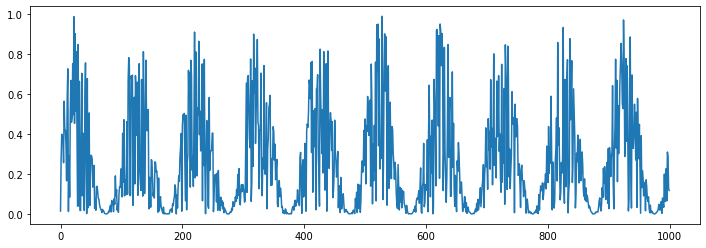

In [367]:
#generate an artificial dataset that is amplitude-modulated white noise
from numpy.random import default_rng
rng = default_rng()
time_points = 10000
wave_signal = 0.5 * (1.0+np.sin(np.linspace(0,2*np.pi*100, time_points)))
random_signal = rng.random(time_points)  #values in 0...1
modulated_signal = np.multiply(wave_signal,random_signal)
plt.figure(figsize=(12,4), linewidth = 1)
plt.plot(modulated_signal[0:1000]);

We need to convert these  values into probabilities of state.  Because we know each integer, the probability vector will have a 1 corresponding to the known correct answer, and 0 for each of the other (incorrect) answers.  Thus we change every value $i$ into a probability vector $P[x=i]$, which is a vector with a single value of 1 for the correct answer.  Of course, the sum of the vector is 1 so this is a valid probability.

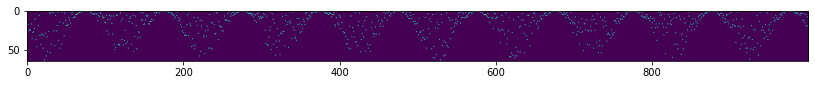

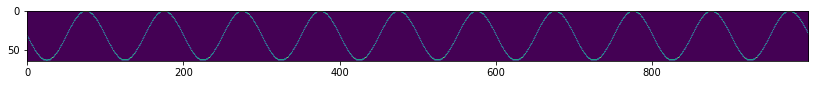

In [368]:
#encode the state in a state vector representing the probabilities.  These are the actual measured states, so prob=1 for the correct state
#however, the states here are not integers, so we need to interpolate
def to_distributed(data, nstates=128, timepoints=1000):
  d = data - min(data)
  dscale = ((nstates-1)*d/np.max(d))
  vec = np.zeros((timepoints, nstates), dtype = int)
  vec[np.arange(timepoints),dscale.astype(int)] = 1
  return vec

n_states = 64   #this is arbitrary. sets the precision
vModulated = to_distributed(modulated_signal, n_states, time_points)
dfModulated = pd.DataFrame(data=vModulated, index=np.arange(time_points)) 
plt.figure(figsize=(14,1))
plt.imshow(vModulated[0:1000,:].transpose())
vWave = to_distributed(wave_signal, n_states, time_points)
dfWave = pd.DataFrame(data=vWave, index=np.arange(time_points)) 
plt.figure(figsize=(14,1))
plt.imshow(vWave[0:1000,:].transpose());

#Step 1: learn p(z|x)

In the first model, we will just learn the likelihood function $p(z|x)$ by using $x$ as input and $z$ as output.  Note that for any given $x$, this will give a true probability $p(z|x)$ where $\sum_z p(z|x)=1$, but for any given $z$ this is a likelihood such that $\sum_x p(z|x) \neq 1$.  

In [369]:
from tensorflow.python.keras.engine.base_layer_utils import uses_keras_history
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
n_features = n_states
n_hidden = n_states
predict_length = 1
model = Sequential()
model.add(Flatten(input_shape = (1,n_features)))
model.add(Dense(n_features, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy')
model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_24 (Flatten)        (None, 64)                0         
                                                                 
 dense_23 (Dense)            (None, 64)                4160      
                                                                 
Total params: 4,160
Trainable params: 4,160
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#need to reshape the input data because numpy expects a 1xn_states array, rather than a vector of n_states.  this is why I use matlab.
model.fit(vWave.reshape(time_points,1,n_states),vModulated, validation_split=0.1, batch_size=16, epochs=10, verbose=1)
#model.fit(generator, epochs=5)  #if you want to do these in time sequence, which does not matter here
losses = pd.DataFrame(model.history.history)
losses.plot()

Epoch 1/10
563/563 [==============================] - 2s 2ms/step - loss: 3.9819 - val_loss: 3.8169
Epoch 2/10
378/563 [===================>..........] - ETA: 0s - loss: 3.6897

The weight matrix is $p(z|x)$

In [ ]:

#pzx = np.maximum(model.weights[0], np.zeros(model.weights[0].shape))
pzx = np.exp(model.weights[0])
row_sums = pzx.sum(axis=1)
pzx = pzx / row_sums.reshape(n_states,1);
plt.imshow(np.log(pzx))
plt.xlabel('z')
plt.ylabel('x');



#Step 2: learn $p(x(t)|x(t-1)$

This is the update rule, and the weights will be the Markov matrix $M$.  

Now we need a timeseries generator because we are going to predict $p(x,t)$ from $p(x,t-1)$

In [ ]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
predict_length = 1
generator = TimeseriesGenerator(dfWave.values, dfWave.values, length =predict_length , batch_size=16)  
#NOTE1:  you have to use df.values or you get weird indexing errors


In [ ]:
#same model, but we have to recreate it otherwise will start with the weights from the last one
n_features = n_states
n_hidden = n_states
predict_length = 1
model = Sequential()
model.add(Flatten(input_shape = (1,n_features)))
model.add(Dense(n_features, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy')
model.summary()

In [ ]:
#we can use the same model here
model.fit(generator, epochs=5)

In [ ]:
#pxx = np.maximum(model.weights[0], np.zeros(model.weights[0].shape))
pxx = np.exp(model.weights[0])
row_sums = pxx.sum(axis=1)
row_sums[row_sums==0]=1   #just in case there was no data
pxx = pxx / row_sums.reshape(n_states,1);
plt.imshow(np.log(pxx))
plt.xlabel('x(t)')
plt.ylabel('x(t-1)');

In [ ]:
px = np.ones(n_states)/n_states  #initial state is uniform (unknown values of x)
px_all = np.zeros((n_states,time_points))
for t in range(0,time_points):
  px = pxx.dot(px)          #time update p(x,t) = Mp(x,t-1)
  likelihood = pzx.dot(vModulated[t,:].transpose())  #z'th column of pzx is the likelihood p(z(t)|x)
  px = np.multiply(px, likelihood)  #Bayes rule
  px = px / px.sum()                #normalize so it's a probability
  px_all[:,t]=px / px.max()  #for display purposes
plt.figure(figsize=(12,2))
plt.matshow(px_all[:,0:1000])
dfPxAll = pd.DataFrame(px_all.transpose())
predicted_x = dfPxAll.idxmax(axis=1)
plt.figure(figsize=(16,1))
plt.plot(predicted_x[0:1000]);

#Nonlinear Filtering EMG

Now we will do the same thing with an EMG dataset.  There is not enough data here to do this well, but you can see how it would work

In [ ]:
#load the sample EMG data
arEMG = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/EMGdata.csv')
dfEMG = pd.DataFrame(arEMG)
plt.figure()
plt.subplot(211)
plt.plot(dfEMG['Torque'],'r')
plt.title('Torque')
plt.subplot(212)
plt.plot(dfEMG['Biceps'])
plt.title('Biceps')
wave_signal = dfEMG['Torque'].to_numpy()
wave_signal = wave_signal - wave_signal[0:200].mean()  #make start at zero
modulated_signal = dfEMG['Biceps'].to_numpy()
modulated_signal = modulated_signal - modulated_signal[0:200].mean()  #use the first few points to find the zero
modulated_signal = np.absolute(modulated_signal)  #rectify the EMG
time_points = len(wave_signal)
plt.figure()
plt.plot(modulated_signal)
plt.plot(wave_signal * modulated_signal.max()/wave_signal.max(),'r')
plt.title('rectified EMG and Torque')

dfEMG

In [ ]:
#turn into probability vectors
n_states = 64   #this is arbitrary. sets the precision
vModulated = to_distributed(modulated_signal, n_states, time_points)
dfModulated = pd.DataFrame(data=vModulated, index=np.arange(time_points)) 
plt.figure(figsize=(14,1))
plt.imshow(vModulated[np.arange(0,time_points,20)].transpose())
vWave = to_distributed(wave_signal, n_states, time_points)
dfWave = pd.DataFrame(data=vWave, index=np.arange(time_points)) 
plt.figure(figsize=(14,1))
plt.imshow(vWave[np.arange(0,time_points,20)].transpose());

In [ ]:
n_features = n_states
n_hidden = n_states
predict_length = 1
model = Sequential()
model.add(Flatten(input_shape = (1,n_features)))
model.add(Dense(n_features, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy')
model.summary()

In [ ]:
#need to reshape the input data because numpy expects a 1xn_states array, rather than a vector of n_states.  this is why I use matlab.
model.fit(vWave.reshape(time_points,1,n_states),vModulated, validation_split=0.1, batch_size=16, epochs=10, verbose=1)
#model.fit(generator, epochs=5)  #if you want to do these in time sequence, which does not matter here
losses = pd.DataFrame(model.history.history)
losses.plot()

In [ ]:
pzx = np.exp(model.weights[0])
row_sums = pzx.sum(axis=1)
pzx = pzx / row_sums.reshape(n_states,1);
#pzx = pzx + 0.01  #make sure that it does not have any zeros
#pzx = pzx / row_sums.reshape(n_states,1);  #renormalize
plt.imshow(np.log(pzx))
plt.xlabel('z')
plt.ylabel('x');

In [ ]:
generator = TimeseriesGenerator(dfWave.values, dfWave.values, length =predict_length , batch_size=16) 

n_features = n_states
n_hidden = n_states
predict_length = 1
model = Sequential()
model.add(Flatten(input_shape = (1,n_features)))
model.add(Dense(n_features, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy')
model.summary()

In [ ]:
model.fit(generator, epochs=5)

In this case, the measurements are very noisy, and most measurements give very little useful data.  So it is not unreasonable to weight the prior more highly than the measurement, which we do by basically repeating the update without using the measurement at all.  This corresponds to

\begin{equation}
p(x,t+) = p(z(t)|x)M^Np(x,t-1) / C
\end{equation}

as if we took $N-1$ steps without a measurement, and then did measurements only very $N$ steps.


In [ ]:
prior_weight = 50   #how much to believe the prior relative to the measurement
pxx = np.exp(prior_weight*model.weights[0])    
pxx = np.nan_to_num(pxx)
row_sums = pxx.sum(axis=1)
row_sums[row_sums==0]=1   #just in case there was no data
pxx = pxx / row_sums.reshape(n_states,1);
plt.imshow(np.log(pxx))
plt.xlabel('x(t)')
plt.ylabel('x(t-1)');

In [ ]:
px = np.ones(n_states)/n_states  #initial state is uniform (unknown values of x)
px_all = np.zeros((n_states,time_points))
for t in range(0,time_points):
  px = pxx.dot(px)          #time update p(x,t) = Mp(x,t-1)
  likelihood = pzx.dot(vModulated[t,:].transpose())  #z'th column of pzx is the likelihood p(z(t)|x)
  px = np.multiply(px, likelihood)  #Bayes rule
  px = px / px.sum()                #normalize so it's a probability
  px_all[:,t]=px / px.max()  #for display purposes
plt.figure(figsize=(12,2))
plt.matshow(px_all[:,np.arange(0,time_points,20)])
dfPxAll = pd.DataFrame(px_all.transpose())
predicted_x = dfPxAll.idxmax(axis=1)
plt.figure(figsize=(16,3))
plt.plot(modulated_signal*predicted_x.max()/modulated_signal.max(),'y');
plt.plot(predicted_x);
plt.plot(wave_signal*predicted_x.max()/wave_signal.max(),'r');